In [2]:
# The following preliminary analyses come from a Visual Search Task performed by two different samples: older vs younger adults.

# In this particular task: 
# the set size of the stimuli presented varied according to 3 levels (5, 7 or 10 stimuli in total displayed);
# the difficulty of the visual search also varied according to 3 levels 
### (Baseline, where stimuli could come from any conceptual category -such as kitchen materials, tools, clothing, ...- and any color category -such as blue, brown, black,...-;
### High Concept, where stimuli could come only from one conceptual category but could be in different colors;
### High Color, where stimuli could only be in one color but could come from different conceptual categories);
# the Target that had to be searched for could be present or not.

# Both Reaction Time (RT) and accuracy were measured.

import numpy as np
import pandas as pd
import random
import itertools
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import seaborn as sns

In [3]:
# STEP 1. generation of some data

# ensure reproducibility by putting a seed
np.random.seed(42)
random.seed(42)

# define variables levels
Nfig_levels = [5, 7, 10]  
Tipo_levels = ['Baseline', 'Hconc', 'Hcol'] 
TargetPresence_levels = ['T', 'NoT']
Group_levels = ['OLD', 'YOUNG']

# define the sample size
n_samples = 30

# define the number of participants per group
n_participants_per_group = 30

# define the total number of participants
n_participants_tot = n_participants_per_group * len(Group_levels)

# define the total number of trials for each combination of conditions
total_trials_per_condition = 40

# create a function for the data generation according to some boundaries
def generate_ideal_data():
    data = []
    # initialize participant ID
    participant_id = 1 
    
    # loop through each group level (YOUNG and OLD)
    for group in Group_levels:
        # loop through each participant within the group
        for _ in range(n_participants_per_group):
            # loop through each combination of Nfig, Tipo, and TargetPresence levels (so that it will generate RT and accuracy based on these combinations)
            for Nfig, Tipo, TargetPresence in itertools.product(Nfig_levels, Tipo_levels, TargetPresence_levels): # itertools.product to generate all possible combinations of the levels of the independent variables
                # define the baseline of RT according to the group
                if group == 'YOUNG':
                    base_rt = 0.71
                else:  # Group == 'OLD'
                    base_rt = 0.89
                # YOUNG are faster than OLD
                    
                # generate RT as a function of the predictors
                rt_nfig = (Nfig - 5) * 1.13  # increase by 1.45 for each additional level of difficulty compared to the easier level
                rt_tipo = 0.91 if Tipo == 'Baseline' else (1.09 if Tipo == 'Hconc' else 1.2) # adjusting RT based on Tipo
                rt_target = 0.8 if TargetPresence == 'T' else 1.56 # adjusting RT based on TargetPresence
                rt_group = 0.97 if group == 'YOUNG' else 1.1 # adjusting RT based on Group
                
                # apply the baseline value
                rt = base_rt * (1 + (rt_nfig + rt_tipo + rt_target + rt_group) / 100)
                
                # Add interaction effects (e.g., Tipo might interact with TargetPresence)
                if Tipo != 'Baseline' and TargetPresence == 'NoT':
                    rt += 0.15  # Increase RT for non-baseline tasks when target is not present

                # Add some random noise for RT, with higher noise for more difficult tasks
                difficulty = rt_nfig + rt_tipo + rt_target + rt_group
                noise_level = 0.3 + 0.1 * (difficulty / 50)  # Increase noise with difficulty
                rt += np.random.normal(0, noise_level)
                
                # add some random noise for RT
                #rt += random.normalvariate(0, 0.3)
                
                # boundaries for RT (ex. no negative values but also not too close to 0)
                rt = max(0.15, min(rt, 4))
                
                # Add small random buffer to avoid hitting the exact boundaries
                if rt == 0.15:
                    rt += np.random.uniform(0.01, 0.02)  # Slightly increase to avoid the lower boundary
                if rt == 4:
                    rt -= np.random.uniform(0.01, 0.02)  # Slightly decrease to avoid the upper boundary

                # the resulting RT will be the mean RT for each participant for each condition combination
                    
                # define the baseline of Accuracy according to the group
                if group == 'YOUNG':
                    base_accuracy = 0.87
                else:  # Group == 'OLD'
                    base_accuracy = 0.96
                # OLD are more accurate than YOUNG
                
                # generate accuracy as a function of the predictors
                acc_nfig = -0.01 if Nfig == 5 else (-0.09 if Nfig == 7 else -0.13)  # adjust accuracy based on Nfig (decreasing with higher Nfig)
                acc_tipo = 0.02 if Tipo == 'Baseline' else (-0.03 if Tipo == 'Hconc' else -0.06) # adjust accuracy based on Tipo
                acc_target = 0 if TargetPresence == 'NoT' else -0.05 # adjust accuracy based on TargetPresence
                acc_group = 0.03 if group == 'OLD' else -0.03 # adjust accuracy based on Group
                
                # apply the baseline value
                accuracy = base_accuracy + acc_nfig + acc_tipo + acc_target + acc_group
                
                # Add interaction effects (e.g., Tipo might interact with TargetPresence)
                if Tipo != 'Baseline' and TargetPresence == 'T':
                    accuracy -= 0.02  # Decrease accuracy for non-baseline tasks when target is present

                # Add some random noise for Accuracy, with higher noise for more difficult tasks
                difficulty = abs(acc_nfig) + abs(acc_tipo) + abs(acc_target) + abs(acc_group)
                noise_level = 0.05 + 0.02 * (difficulty / 0.5)  # Increase noise with difficulty
                accuracy += np.random.normal(0, noise_level)
                
                # add some random noise for Accuracy
                #accuracy += random.normalvariate(0, 0.3)
                
                # boundaries for Accuracy 0.65 e 1
                accuracy = max(0.65, min(1, accuracy))
                
                # Add small random buffer to avoid hitting the exact boundaries
                if accuracy == 0.65:
                    accuracy += np.random.uniform(0.01, 0.02)  # Slightly increase to avoid the lower boundary
                
                # the resulting Accuracy will be the mean accuracy for each participant for each condition combination
                
                # calculate the number of correct trials based on accuracy
                correct_trials = round(accuracy * total_trials_per_condition)
                
                data.append([participant_id, Nfig, Tipo, TargetPresence, group, rt, accuracy, correct_trials])
            
            participant_id += 1
    
    return pd.DataFrame(data, columns=['ID', 'Nfig', 'Tipo', 'TargetPresence', 'Group', 'RT', 'Accuracy', 'correct_trials'])

# generate data
df_ideal = generate_ideal_data()

print(df_ideal.head(50))
print(df_ideal.tail(50))

# Save to an Excel file
df_ideal.to_excel('ideal_data.xlsx', index=False)

    ID  Nfig      Tipo TargetPresence Group        RT  Accuracy  \
0    1     5  Baseline              T   OLD  1.066815  0.942478   
1    1     5  Baseline            NoT   OLD  1.120704  1.000000   
2    1     5     Hconc              T   OLD  0.844965  0.867169   
3    1     5     Hconc            NoT   OLD  1.558983  0.990521   
4    1     5      Hcol              T   OLD  0.773837  0.880383   
5    1     5      Hcol            NoT   OLD  0.931751  0.894851   
6    1     7  Baseline              T   OLD  1.010165  0.759795   
7    1     7  Baseline            NoT   OLD  0.404299  0.888737   
8    1     7     Hconc              T   OLD  0.622241  0.818226   
9    1     7     Hconc            NoT   OLD  0.810167  0.790911   
10   1     7      Hcol              T   OLD  1.393110  0.756634   
11   1     7      Hcol            NoT   OLD  1.115553  0.758504   
12   1    10  Baseline              T   OLD  0.792768  0.836567   
13   1    10  Baseline            NoT   OLD  0.605536  0.90149

In [4]:
# STEP 2. T-test RT

# t-test mean RT OLD vs YOUNG not considering any predictor
rt_old = df_ideal[df_ideal['Group'] == 'OLD']['RT']
rt_young = df_ideal[df_ideal['Group'] == 'YOUNG']['RT']

t_stat, p_value = ttest_ind(rt_old, rt_young)
print(f"t-statistic: {t_stat}, p-value: {p_value}")

t-statistic: 9.615681863361543, p-value: 4.668850392025545e-21


YOUNG mean RT: 0.7959586846934951, YOUNG SE: 0.013481043327409186
OLD mean RT: 0.983445726703313, OLD SE: 0.014086710383010986 


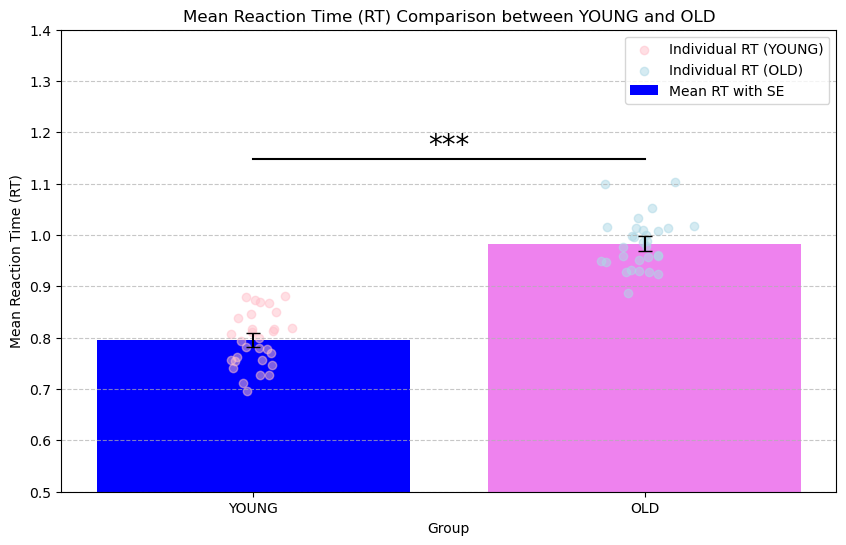

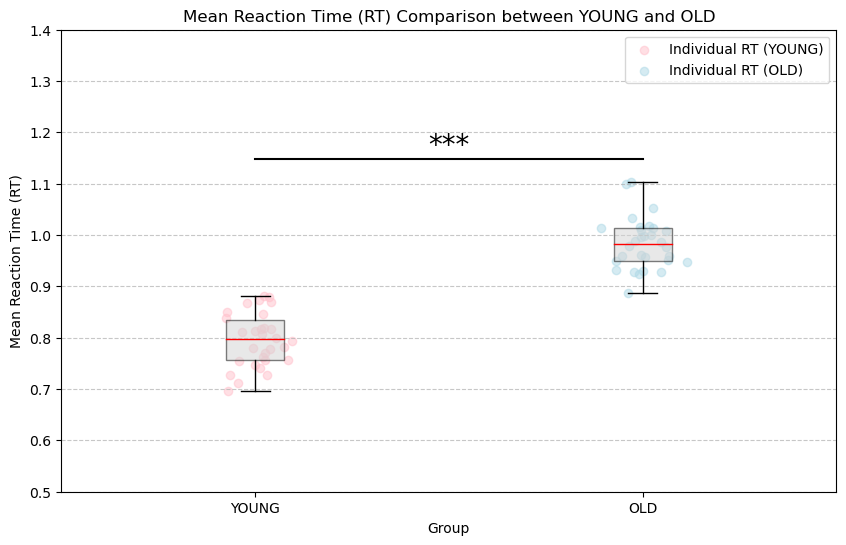

In [26]:
# STEP 3. visualization of mean RT OLD vs YOUNG not considering any predictor

# calculate mean RT and standard error for YOUNG and OLD
mean_rt_young = df_ideal[df_ideal['Group'] == 'YOUNG']['RT'].mean()
std_err_young = df_ideal[df_ideal['Group'] == 'YOUNG']['RT'].sem()
mean_rt_old = df_ideal[df_ideal['Group'] == 'OLD']['RT'].mean()
std_err_old = df_ideal[df_ideal['Group'] == 'OLD']['RT'].sem() 
print(f"YOUNG mean RT: {mean_rt_young}, YOUNG SE: {std_err_young}")
print(f"OLD mean RT: {mean_rt_old}, OLD SE: {std_err_old} ")

# mean RT for each participant considering all conditions together
mean_rt_young_ID = df_ideal[df_ideal['Group'] == 'YOUNG'].groupby('ID')['RT'].mean()
mean_rt_old_ID = df_ideal[df_ideal['Group'] == 'OLD'].groupby('ID')['RT'].mean()

# create a BAR plot
plt.figure(figsize=(10, 6))
plt.bar(['YOUNG', 'OLD'], [mean_rt_young, mean_rt_old], yerr=[std_err_young, std_err_old], capsize=5, color=['blue', 'violet'], label='Mean RT with SE')

# in order to visualize also single data points, create a jitter for each participant's data point
jitter_y = np.random.normal(loc=0, scale=0.05, size=len(mean_rt_young_ID))
jitter_o = np.random.normal(loc=0, scale=0.05, size=len(mean_rt_old_ID))

# add individual participant RTs as jittered data points
plt.scatter(np.zeros(len(mean_rt_young_ID)) + jitter_y, mean_rt_young_ID, color='pink', alpha=0.5, label='Individual RT (YOUNG)')
plt.scatter(np.ones(len(mean_rt_old_ID)) + jitter_o, mean_rt_old_ID, color='lightblue', alpha=0.5, label='Individual RT (OLD)')

# following the t-test results, add significance star if any
if p_value < 0.001:
    sig = '***'  # Highly significant
elif p_value < 0.01:
    sig = '**'  # Very significant
elif p_value < 0.05:
    sig = '*'  # Significant
else:
    sig = 'n.s.'  # Not significant
    
# position of the star or "n.s." is midway of the bars, slightly above the highest error bar
plt.text(0.5, max(mean_rt_young + std_err_young, mean_rt_old + std_err_old) + 0.15, sig, ha='center', va='bottom', color='black', fontsize=20)

# add line connecting the bars
y_max = max(mean_rt_young + std_err_young, mean_rt_old + std_err_old) + 0.15
plt.plot([0, 1], [y_max, y_max], color='black')

plt.xlabel('Group')
plt.ylabel('Mean Reaction Time (RT)')
plt.title('Mean Reaction Time (RT) Comparison between YOUNG and OLD')
plt.ylim(0.5, 1.4)  # Set y-axis range
plt.xticks([0, 1], ['YOUNG', 'OLD'])
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

# create a BOXPLOT
plt.figure(figsize=(10, 6))
data = [mean_rt_young_ID, mean_rt_old_ID]
plt.boxplot(data, labels=['YOUNG', 'OLD'], patch_artist=True, boxprops=dict(facecolor='lightgrey', color='black', alpha=0.5), medianprops=dict(color='red'))

# In order to visualize also single data points, create a jitter for each participant's data point
jitter_y = np.random.normal(loc=1, scale=0.05, size=len(mean_rt_young_ID))
jitter_o = np.random.normal(loc=2, scale=0.05, size=len(mean_rt_old_ID))

# Add individual participant RTs as jittered data points
plt.scatter(jitter_y, mean_rt_young_ID, color='pink', alpha=0.5, label='Individual RT (YOUNG)')
plt.scatter(jitter_o, mean_rt_old_ID, color='lightblue', alpha=0.5, label='Individual RT (OLD)')

# Following the t-test results, add significance star if any
if p_value < 0.001:
    sig = '***'  # Highly significant
elif p_value < 0.01:
    sig = '**'  # Very significant
elif p_value < 0.05:
    sig = '*'  # Significant
else:
    sig = 'n.s.'  # Not significant

# Position of the star or "n.s." is midway of the boxes, slightly above the highest box
plt.text(1.5, max(mean_rt_young + std_err_young, mean_rt_old + std_err_old) + 0.15, sig, ha='center', va='bottom', color='black', fontsize=20)

# Add line connecting the boxes
y_max = max(mean_rt_young + std_err_young, mean_rt_old + std_err_old) + 0.15
plt.plot([1, 2], [y_max, y_max], color='black')

plt.xlabel('Group')
plt.ylabel('Mean Reaction Time (RT)')
plt.title('Mean Reaction Time (RT) Comparison between YOUNG and OLD')
plt.ylim(0.5, 1.4)  # Set y-axis range
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

In [6]:
# STEP 4. checking assumptions for parametric methods

# Assumption 1: Normality of the residuals
shapiro_test_rt = stats.shapiro(df_ideal['RT'])
print(f"Shapiro-Wilk test for RT: statistic = {shapiro_test_rt.statistic}, p-value = {shapiro_test_rt.pvalue}")

# KIND AND CURIOUS QUESTION FOR WHO IS CURRENTLY LOOKING AT MY CODE:
# HOW DO I MAKE IT POSSIBLE FOR THE RESIDUALS OF THE MODEL OF MY IDEAL DATA TO FOLLOW A NORMAL DISTRIBUTION?

# MOREOVER, IN R I WOULD USE THE Aligned Rank Transform (ART) AS A NON-PARAMETRIC TECHNIQUE USED FOR FACTORIAL DATA ANALYSIS THROUGH THE PACKAGE ARTool BUT I DIDN'T FIND SOMETHING SIMILAR FOR PYTHON
# WHAT SHOULD BE DONE IN MY CASE THAN?

# Assumption 2: Homogeneity of variance
levene_test = stats.levene(df_ideal['RT'][df_ideal['Group'] == 'YOUNG'],
                            df_ideal['RT'][df_ideal['Group'] == 'OLD'])
print(f"Levene's test statistic: {levene_test.statistic}, p-value: {levene_test.pvalue}")

Shapiro-Wilk test for RT: statistic = 0.9955830574035645, p-value = 0.003271837253123522
Levene's test statistic: 0.057849848046657985, p-value: 0.8099729286953744


In [7]:
# STEP 5. ANOVA (or non-parametric test)

# create a formula for the ANOVA
formula = 'RT ~ C(Group) + C(Nfig) + C(Tipo) + C(TargetPresence) + C(Group):C(Nfig) + C(Group):C(Tipo) + C(Group):C(TargetPresence) + C(Group):C(Nfig):C(Tipo) + C(Group):C(Nfig):C(TargetPresence) + C(Group):C(Tipo):C(TargetPresence)'

model = ols(formula, df_ideal).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)

                                        sum_sq      df          F  \
C(Group)                              9.490876     1.0  99.280508   
C(Nfig)                               1.746685     2.0   9.135710   
C(Tipo)                               3.320669     2.0  17.368138   
C(TargetPresence)                     1.962202     1.0  20.525862   
C(Group):C(Nfig)                      0.253308     2.0   1.324882   
C(Group):C(Tipo)                      0.014041     2.0   0.073439   
C(Group):C(TargetPresence)            0.000020     1.0   0.000208   
C(Group):C(Nfig):C(Tipo)              1.041019     8.0   1.361214   
C(Group):C(Nfig):C(TargetPresence)    0.414063     4.0   1.082840   
C(Group):C(Tipo):C(TargetPresence)    1.333833     4.0   3.488183   
Residual                            100.567587  1052.0        NaN   

                                          PR(>F)  
C(Group)                            2.078353e-22  
C(Nfig)                             1.165394e-04  
C(Tipo)           

In [8]:
# STEP 6. POST-HOC tests

# perform post-hoc test for 'Group'
posthoc_group = pairwise_tukeyhsd(df_ideal['RT'], df_ideal['Group'], alpha=0.05)
print(posthoc_group)

# perform post-hoc test for 'Nfig'
posthoc_nfig = pairwise_tukeyhsd(df_ideal['RT'], df_ideal['Nfig'], alpha=0.05)
print(posthoc_nfig)

# perform post-hoc test for 'Tipo'
posthoc_tipo = pairwise_tukeyhsd(df_ideal['RT'], df_ideal['Tipo'], alpha=0.05)
print(posthoc_tipo)

# perform post-hoc test for 'TargetPresence'
posthoc_target_presence = pairwise_tukeyhsd(df_ideal['RT'], df_ideal['TargetPresence'], alpha=0.05)
print(posthoc_target_presence)

# create interaction columns
df_ideal['Group_Nfig'] = df_ideal['Group'] + "_" + df_ideal['Nfig'].astype(str)
df_ideal['Group_Tipo'] = df_ideal['Group'] + "_" + df_ideal['Tipo']
df_ideal['Group_TargetPresence'] = df_ideal['Group'] + "_" + df_ideal['TargetPresence']
df_ideal['Group_Nfig_Tipo'] = df_ideal['Group'] + "_" + df_ideal['Nfig'].astype(str) + "_" + df_ideal['Tipo']
df_ideal['Group_Nfig_TargetPresence'] = df_ideal['Group'] + "_" + df_ideal['Nfig'].astype(str) + "_" + df_ideal['TargetPresence']
df_ideal['Group_Tipo_TargetPresence'] = df_ideal['Group'] + "_" + df_ideal['Tipo'] + "_" + df_ideal['TargetPresence']

# post-hoc test for 'Group:Nfig' interaction
posthoc_group_nfig = pairwise_tukeyhsd(df_ideal['RT'], df_ideal['Group_Nfig'], alpha=0.05)
print(posthoc_group_nfig)

# post-hoc test for 'Group:Tipo' interaction
posthoc_group_tipo = pairwise_tukeyhsd(df_ideal['RT'], df_ideal['Group_Tipo'], alpha=0.05)
print(posthoc_group_tipo)

# post-hoc test for 'Group:TargetPresence' interaction
posthoc_group_target_presence = pairwise_tukeyhsd(df_ideal['RT'], df_ideal['Group_TargetPresence'], alpha=0.05)
print(posthoc_group_target_presence)

# post-hoc test for 'Group:Nfig:Tipo' interaction
posthoc_group_nfig_tipo = pairwise_tukeyhsd(df_ideal['RT'], df_ideal['Group_Nfig_Tipo'], alpha=0.05)
print(posthoc_group_nfig_tipo)

# post-hoc test for 'Group:Nfig:TargetPresence' interaction
posthoc_group_nfig_target_presence = pairwise_tukeyhsd(df_ideal['RT'], df_ideal['Group_Nfig_TargetPresence'], alpha=0.05)
print(posthoc_group_nfig_target_presence)

# post-hoc test for 'Group:Tipo:TargetPresence' interaction
posthoc_group_tipo_target_presence = pairwise_tukeyhsd(df_ideal['RT'], df_ideal['Group_Tipo_TargetPresence'], alpha=0.05)
print(posthoc_group_tipo_target_presence)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
   OLD  YOUNG  -0.1875   0.0 -0.2257 -0.1492   True
---------------------------------------------------
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     5      7   0.0342 0.3488 -0.0238 0.0922  False
     5     10   0.0971 0.0003  0.0391 0.1551   True
     7     10   0.0629 0.0298  0.0049 0.1209   True
---------------------------------------------------
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1  group2 meandiff p-adj   lower  upper  reject
-----------------------------------------------------
Baseline   Hcol   0.0983 0.0002  0.0407  0.156   True
Baseline  Hconc   0.1303    0.0  0.0727 0.1879   True
    Hcol  Hconc    0.032 0.3941 -0.0256 0.0896  False
----------------------------------------------------

      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
  OLD_10_NoT     OLD_10_T  -0.0956  0.671 -0.2496  0.0584  False
  OLD_10_NoT    OLD_5_NoT  -0.1031 0.5555 -0.2571  0.0509  False
  OLD_10_NoT      OLD_5_T  -0.2379    0.0 -0.3919 -0.0838   True
  OLD_10_NoT    OLD_7_NoT  -0.0866  0.795 -0.2406  0.0675  False
  OLD_10_NoT      OLD_7_T  -0.1128 0.4079 -0.2668  0.0412  False
  OLD_10_NoT YOUNG_10_NoT  -0.1849 0.0051 -0.3389 -0.0309   True
  OLD_10_NoT   YOUNG_10_T  -0.3051    0.0 -0.4591 -0.1511   True
  OLD_10_NoT  YOUNG_5_NoT  -0.2956    0.0 -0.4496 -0.1416   True
  OLD_10_NoT    YOUNG_5_T  -0.3375    0.0 -0.4915 -0.1835   True
  OLD_10_NoT  YOUNG_7_NoT  -0.2725    0.0 -0.4265 -0.1184   True
  OLD_10_NoT    YOUNG_7_T  -0.3653    0.0 -0.5193 -0.2112   True
    OLD_10_T    OLD_5_NoT  -0.0075    1.0 -0.1615  0.1465  False
    OLD_10_T      OLD_5_T

Mean RT for Nfig=5, Tipo=Baseline, TargetPresence=T, Group=OLD: 0.8494117543515987, SE: 0.06211141220879308
Mean RT for Nfig=5, Tipo=Baseline, TargetPresence=T, Group=YOUNG: 0.6871641151263409, SE: 0.05758809076191021
Mean RT for Nfig=5, Tipo=Baseline, TargetPresence=NoT, Group=OLD: 0.9308799860182543, SE: 0.06442029597702441
Mean RT for Nfig=5, Tipo=Baseline, TargetPresence=NoT, Group=YOUNG: 0.677102771732249, SE: 0.06234096991173158
Mean RT for Nfig=5, Tipo=Hconc, TargetPresence=T, Group=OLD: 0.835150131961023, SE: 0.047819005636368886
Mean RT for Nfig=5, Tipo=Hconc, TargetPresence=T, Group=YOUNG: 0.8074843195939487, SE: 0.059148195705897966
Mean RT for Nfig=5, Tipo=Hconc, TargetPresence=NoT, Group=OLD: 1.0223393995645083, SE: 0.0546931088670084
Mean RT for Nfig=5, Tipo=Hconc, TargetPresence=NoT, Group=YOUNG: 0.8597696107287229, SE: 0.040444802645743655
Mean RT for Nfig=5, Tipo=Hcol, TargetPresence=T, Group=OLD: 0.8701623469115117, SE: 0.057004636390958825
Mean RT for Nfig=5, Tipo=Hc

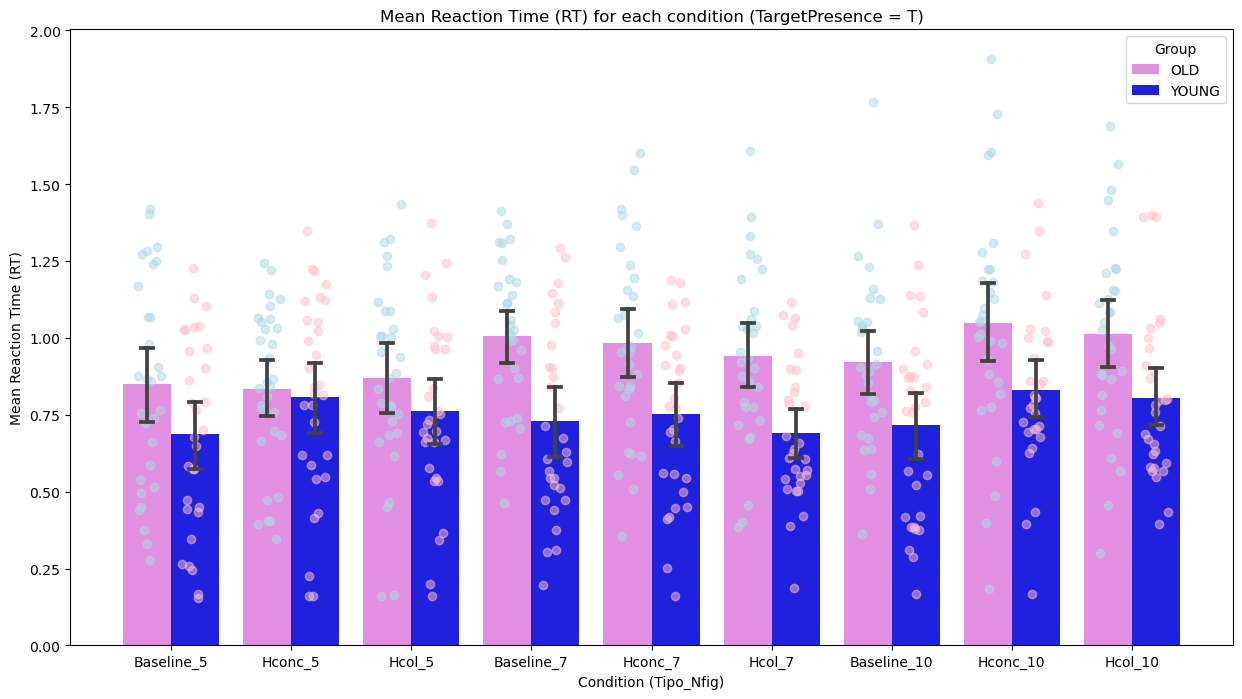

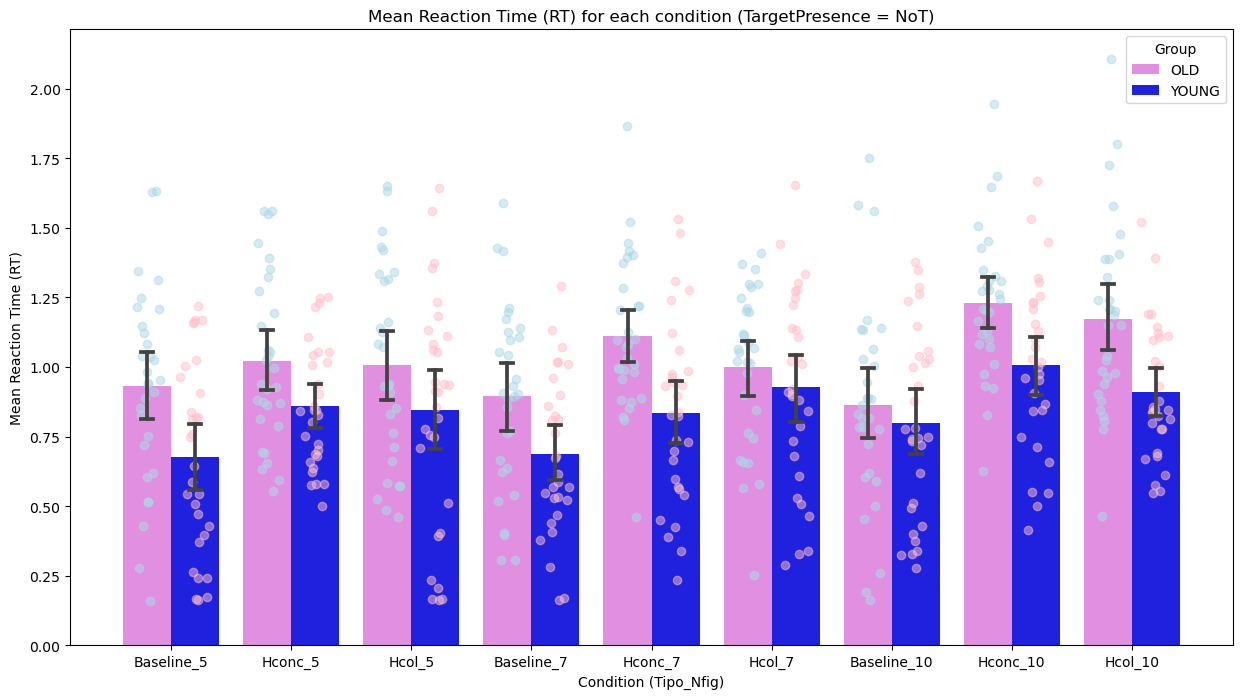

In [9]:
# STEP 7. visualization of mean RT OLD vs YOUNG considering predictors interactions

# calculate the mean RT for each possible interaction of all levels of the conditions
for Nfig in Nfig_levels:
    for Tipo in Tipo_levels:
        for TargetPresence in TargetPresence_levels:
            for Group in Group_levels:
                # filter the dataframe based on the current levels
                df_filtered = df_ideal[(df_ideal['Nfig'] == Nfig) &
                                                      (df_ideal['Tipo'] == Tipo) &
                                                      (df_ideal['TargetPresence'] == TargetPresence) &
                                                      (df_ideal['Group'] == Group)]
                
                # calculate the mean RT and standard error
                mean_rt = df_filtered['RT'].mean()
                std_err = df_filtered['RT'].sem()
                
                # Print the results
                print(f"Mean RT for Nfig={Nfig}, Tipo={Tipo}, TargetPresence={TargetPresence}, Group={Group}: {mean_rt}, SE: {std_err}")

# initialize a dictionary to store the jitter for each participant
jitter_dict = {}

# calculate the jitter for each possible interaction of all levels of the conditions
for Nfig in Nfig_levels:
    for Tipo in Tipo_levels:
        for TargetPresence in TargetPresence_levels:
            for Group in Group_levels:
                # filter the dataframe based on the current levels
                df_filtered = df_ideal[(df_ideal['Nfig'] == Nfig) &
                                                      (df_ideal['Tipo'] == Tipo) &
                                                      (df_ideal['TargetPresence'] == TargetPresence) &
                                                      (df_ideal['Group'] == Group)]
                
                # get the unique participant IDs
                IDs = df_filtered['ID'].unique()
                
                # calculate the jitter for each participant
                for ID in IDs:
                    jitter = np.random.normal(loc=0, scale=0.05)
                    
                    # store the jitter in the dictionary
                    jitter_dict[(Nfig, Tipo, TargetPresence, Group, ID)] = jitter
                    
# create a new column that combines the Tipo and Nfig levels
df_ideal['Tipo_Nfig'] = df_ideal['Tipo'] + '_' + df_ideal['Nfig'].astype(str)

# create a dictionary to map Group to color
color_dict = {'YOUNG': 'blue', 'OLD': 'violet'}
color_dict2 = {'YOUNG': 'pink', 'OLD': 'lightblue'}

# create two separate plots according to TargetPresence
for TargetPresence in TargetPresence_levels:
    # filter the DataFrame based on the current TargetPresence
    df_filtered = df_ideal[df_ideal['TargetPresence'] == TargetPresence]
    
    # create a bar plot with error bars
    plt.figure(figsize=(15, 8))
    sns.barplot(data=df_filtered, x='Tipo_Nfig', y='RT', hue='Group', palette=color_dict, capsize=.1)
    
    # get the unique 'Tipo_Nfig' values
    unique_Tipo_Nfig = df_filtered['Tipo_Nfig'].unique()
    
    # add individual participant mean RT as jittered data points
    for Group in Group_levels:
        for i, Tipo_Nfig in enumerate(unique_Tipo_Nfig):
            # filter the dataframe based on the current 'Tipo_Nfig' and 'Group'
            df_filtered_Tipo_Nfig_Group = df_filtered[(df_filtered['Tipo_Nfig'] == Tipo_Nfig) & (df_filtered['Group'] == Group)]
            
            # get the unique participant IDs
            IDs = df_filtered_Tipo_Nfig_Group['ID'].unique()
            
            # plot the mean RT for each participant
            for ID in IDs:
                # introduce a horizontal offset for both 'Young' and 'Old' groups
                offset = -0.2 if Group == 'OLD' else 0.2
                # marker = 'x' if Group == 'YOUNG' else 'o'
                plt.scatter(i + offset + jitter_dict[(Nfig, Tipo, TargetPresence, Group, ID)], df_filtered_Tipo_Nfig_Group[df_filtered_Tipo_Nfig_Group['ID'] == ID]['RT'].mean(), color=color_dict2[Group], alpha=0.5) #, marker=marker)    # Set plot title and labels
    
    plt.title(f'Mean Reaction Time (RT) for each condition (TargetPresence = {TargetPresence})')
    plt.xlabel('Condition (Tipo_Nfig)')
    plt.ylabel('Mean Reaction Time (RT)')
    
    # show the plot
    plt.show()

In [10]:
# STEP 8. T-test Accuracy    
    
# t-test mean accuracy OLD vs YOUNG without considering predictors
accuracy_old = df_ideal[df_ideal['Group'] == 'OLD']['Accuracy']
accuracy_young = df_ideal[df_ideal['Group'] == 'YOUNG']['Accuracy']

t_stat, p_value = ttest_ind(accuracy_old, accuracy_young)
print(f"t-statistic: {t_stat}, p-value: {p_value}")

t-statistic: 28.950473039883715, p-value: 8.299226659540848e-137


YOUNG mean Accuracy: 0.7294060228298321, YOUNG SE: 0.0029271733455900856
OLD mean Accuracy: 0.8622628077754401, OLD SE: 0.003534338499727044 


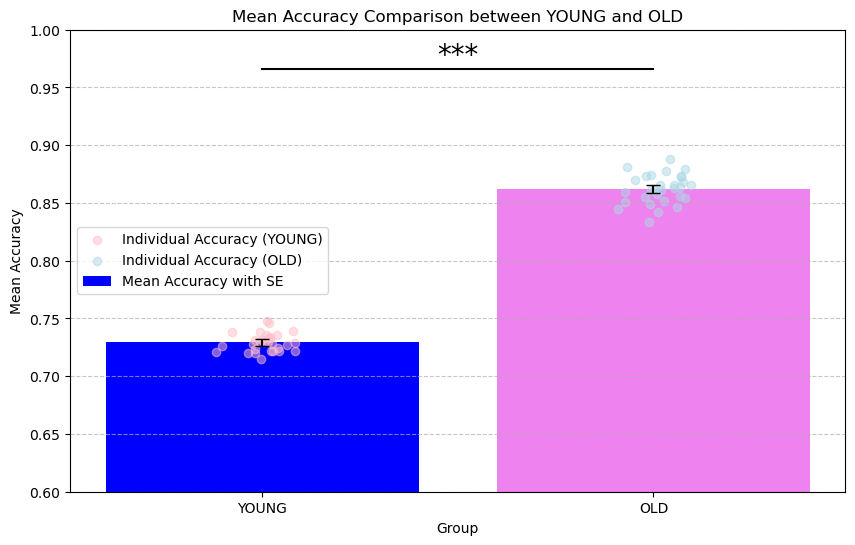

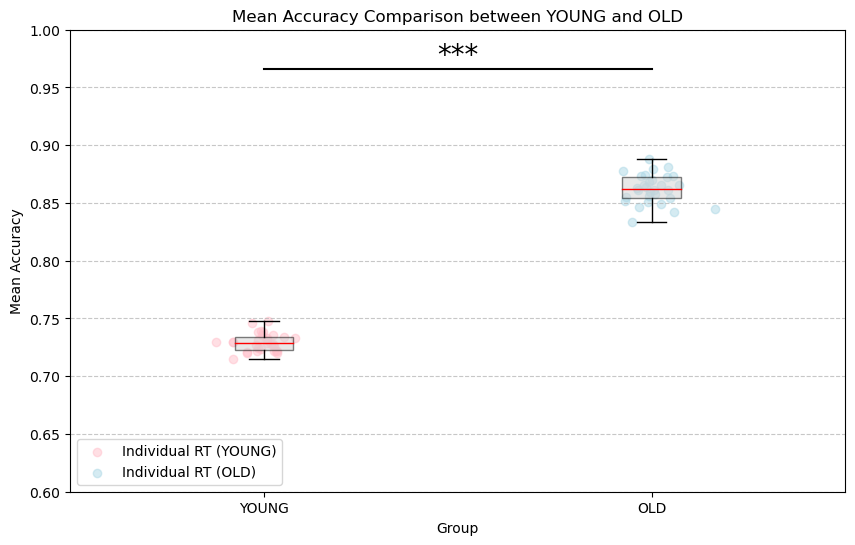

In [30]:
# STEP 9. visualization of mean Accuracy OLD vs YOUNG without considering predictors

# calculate mean accuracy + standard error for YOUNG & OLD
mean_acc_young = df_ideal[df_ideal['Group'] == 'YOUNG']['Accuracy'].mean()
std_err_acc_young = df_ideal[df_ideal['Group'] == 'YOUNG']['Accuracy'].sem()
mean_acc_old = df_ideal[df_ideal['Group'] == 'OLD']['Accuracy'].mean()
std_err_acc_old = df_ideal[df_ideal['Group'] == 'OLD']['Accuracy'].sem() 
print(f"YOUNG mean Accuracy: {mean_acc_young}, YOUNG SE: {std_err_acc_young}")
print(f"OLD mean Accuracy: {mean_acc_old}, OLD SE: {std_err_acc_old} ")

# mean accuracy of each participant
mean_acc_young_ID = df_ideal[df_ideal['Group'] == 'YOUNG'].groupby('ID')['Accuracy'].mean()
mean_acc_old_ID = df_ideal[df_ideal['Group'] == 'OLD'].groupby('ID')['Accuracy'].mean()

# create a BAR plot
plt.figure(figsize=(10, 6))
plt.bar(['YOUNG', 'OLD'], [mean_acc_young, mean_acc_old], yerr=[std_err_acc_young, std_err_acc_old], capsize=5, color=['blue', 'violet'], label='Mean Accuracy with SE')

# create jitter for each participant data point
jitter_y = np.random.normal(loc=0, scale=0.05, size=len(mean_acc_young_ID))
jitter_o = np.random.normal(loc=0, scale=0.05, size=len(mean_acc_old_ID))

# add individual participant accuracy as jittered data points
plt.scatter(np.zeros(len(mean_acc_young_ID)) + jitter_y, mean_acc_young_ID, color='pink', alpha=0.5, label='Individual Accuracy (YOUNG)')
plt.scatter(np.ones(len(mean_acc_old_ID)) + jitter_o, mean_acc_old_ID, color='lightblue', alpha=0.5, label='Individual Accuracy (OLD)')

# add significance star
if p_value < 0.001:
    sig = '***'  # Highly significant
elif p_value < 0.01:
    sig = '**'  # Very significant
elif p_value < 0.05:
    sig = '*'  # Significant
else:
    sig = 'n.s.'  # Not significant
    
# position of the star or "n.s." is midway of the bars, slightly above the highest error bar
plt.text(0.5, max(mean_acc_young + std_err_acc_young, mean_acc_old + std_err_acc_old) + 0.1, sig, ha='center', va='bottom', color='black', fontsize=20)

# add line connecting the bars
y_max = max(mean_acc_young + std_err_acc_young, mean_acc_old + std_err_acc_old) + 0.1
plt.plot([0, 1], [y_max, y_max], color='black')

plt.xlabel('Group')
plt.ylabel('Mean Accuracy')
plt.title('Mean Accuracy Comparison between YOUNG and OLD')
plt.ylim(0.6, 1)  # Set y-axis range
plt.xticks([0, 1], ['YOUNG', 'OLD'])
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()


# create a BOXPLOT
plt.figure(figsize=(10, 6))
data_acc = [mean_acc_young_ID, mean_acc_old_ID]
plt.boxplot(data_acc, labels=['YOUNG', 'OLD'], patch_artist=True, boxprops=dict(facecolor='lightgrey', color='black', alpha=0.5), medianprops=dict(color='red'))

# In order to visualize also single data points, create a jitter for each participant's data point
jitter_y = np.random.normal(loc=1, scale=0.05, size=len(mean_acc_young_ID))
jitter_o = np.random.normal(loc=2, scale=0.05, size=len(mean_acc_old_ID))

# Add individual participant RTs as jittered data points
plt.scatter(jitter_y, mean_acc_young_ID, color='pink', alpha=0.5, label='Individual RT (YOUNG)')
plt.scatter(jitter_o, mean_acc_old_ID, color='lightblue', alpha=0.5, label='Individual RT (OLD)')

# Following the t-test results, add significance star if any
if p_value < 0.001:
    sig = '***'  # Highly significant
elif p_value < 0.01:
    sig = '**'  # Very significant
elif p_value < 0.05:
    sig = '*'  # Significant
else:
    sig = 'n.s.'  # Not significant

# position of the star or "n.s." is midway of the bars, slightly above the highest error bar
plt.text(1.5, max(mean_acc_young + std_err_acc_young, mean_acc_old + std_err_acc_old) + 0.1, sig, ha='center', va='bottom', color='black', fontsize=20)

# add line connecting the bars
y_max = max(mean_acc_young + std_err_acc_young, mean_acc_old + std_err_acc_old) + 0.1
plt.plot([1, 2], [y_max, y_max], color='black')

plt.xlabel('Group')
plt.ylabel('Mean Accuracy')
plt.title('Mean Accuracy Comparison between YOUNG and OLD')
plt.ylim(0.6, 1)  # Set y-axis range
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

In [12]:
# STEP 10. checking assumptions for parametric methods

# Assumption 1: Normality
shapiro_test_accuracy = stats.shapiro(df_ideal['Accuracy'])
print(f"Shapiro-Wilk test for Accuracy: statistic = {shapiro_test_accuracy.statistic}, p-value = {shapiro_test_accuracy.pvalue}")

# Assumption 2: Homogeneity of variance
levene_test_acc = stats.levene(df_ideal['Accuracy'][df_ideal['Group'] == 'YOUNG'],
                            df_ideal['Accuracy'][df_ideal['Group'] == 'OLD'])
print(f"Levene's test statistic: {levene_test_acc.statistic}, p-value: {levene_test_acc.pvalue}")

Shapiro-Wilk test for Accuracy: statistic = 0.9462456107139587, p-value = 2.1868517651006485e-19
Levene's test statistic: 19.30772497194996, p-value: 1.2223874848351802e-05


In [15]:
# STEP 11. ANOVA (or non-parametric test)

# create a formula for the ANOVA
formula2 = 'Accuracy ~ C(Group) + C(Nfig) + C(Tipo) + C(TargetPresence) + C(Group):C(Nfig) + C(Group):C(Tipo) + C(Group):C(TargetPresence) + C(Group):C(Nfig):C(Tipo) + C(Group):C(Nfig):C(TargetPresence) + C(Group):C(Tipo):C(TargetPresence)'

model2 = ols(formula2, df_ideal).fit()
anova_table2 = sm.stats.anova_lm(model2, typ=2)

print(anova_table2)

                                      sum_sq      df            F  \
C(Group)                            4.765750     1.0  2090.288315   
C(Nfig)                             1.868734     2.0   409.819388   
C(Tipo)                             0.978952     2.0   214.687246   
C(TargetPresence)                   0.705330     1.0   309.362409   
C(Group):C(Nfig)                    0.011927     2.0     2.615648   
C(Group):C(Tipo)                    0.011938     2.0     2.618037   
C(Group):C(TargetPresence)          0.038748     1.0    16.995321   
C(Group):C(Nfig):C(Tipo)            0.078099     8.0     4.281839   
C(Group):C(Nfig):C(TargetPresence)  0.032125     4.0     3.522548   
C(Group):C(Tipo):C(TargetPresence)  0.005333     4.0     0.584728   
Residual                            2.398506  1052.0          NaN   

                                           PR(>F)  
C(Group)                            3.221135e-252  
C(Nfig)                             2.463140e-132  
C(Tipo)        

In [14]:
# STEP 12. POST-HOC tests

# perform post-hoc test for 'Group'
posthoc_group = pairwise_tukeyhsd(df_ideal['Accuracy'], df_ideal['Group'], alpha=0.05)
print(posthoc_group)

# perform post-hoc test for 'Nfig'
posthoc_nfig = pairwise_tukeyhsd(df_ideal['Accuracy'], df_ideal['Nfig'], alpha=0.05)
print(posthoc_nfig)

# perform post-hoc test for 'Tipo'
posthoc_tipo = pairwise_tukeyhsd(df_ideal['Accuracy'], df_ideal['Tipo'], alpha=0.05)
print(posthoc_tipo)

# perform post-hoc test for 'TargetPresence'
posthoc_target_presence = pairwise_tukeyhsd(df_ideal['Accuracy'], df_ideal['TargetPresence'], alpha=0.05)
print(posthoc_target_presence)

# post-hoc test for 'Group:Nfig' interaction
posthoc_group_nfig = pairwise_tukeyhsd(df_ideal['Accuracy'], df_ideal['Group_Nfig'], alpha=0.05)
print(posthoc_group_nfig)

# post-hoc test for 'Group:Tipo' interaction
posthoc_group_tipo = pairwise_tukeyhsd(df_ideal['Accuracy'], df_ideal['Group_Tipo'], alpha=0.05)
print(posthoc_group_tipo)

# post-hoc test for 'Group:TargetPresence' interaction
posthoc_group_target_presence = pairwise_tukeyhsd(df_ideal['Accuracy'], df_ideal['Group_TargetPresence'], alpha=0.05)
print(posthoc_group_target_presence)

# post-hoc test for 'Group:Nfig:Tipo' interaction
posthoc_group_nfig_tipo = pairwise_tukeyhsd(df_ideal['Accuracy'], df_ideal['Group_Nfig_Tipo'], alpha=0.05)
print(posthoc_group_nfig_tipo)

# post-hoc test for 'Group:Nfig:TargetPresence' interaction
posthoc_group_nfig_target_presence = pairwise_tukeyhsd(df_ideal['Accuracy'], df_ideal['Group_Nfig_TargetPresence'], alpha=0.05)
print(posthoc_group_nfig_target_presence)

# post-hoc test for 'Group:Tipo:TargetPresence' interaction
posthoc_group_tipo_target_presence = pairwise_tukeyhsd(df_ideal['Accuracy'], df_ideal['Group_Tipo_TargetPresence'], alpha=0.05)
print(posthoc_group_tipo_target_presence)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
   OLD  YOUNG  -0.1329   0.0 -0.1419 -0.1239   True
---------------------------------------------------
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     5      7  -0.0714    0.0 -0.0874 -0.0554   True
     5     10  -0.0987    0.0 -0.1147 -0.0826   True
     7     10  -0.0273 0.0002 -0.0433 -0.0113   True
----------------------------------------------------
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------
Baseline   Hcol  -0.0724    0.0 -0.0892 -0.0556   True
Baseline  Hconc  -0.0485    0.0 -0.0653 -0.0317   True
    Hcol  Hconc   0.0239 0.0025  0.0071  0.0407   True
---------------------------------------

      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
  OLD_10_NoT     OLD_10_T  -0.0749    0.0 -0.1027  -0.047   True
  OLD_10_NoT    OLD_5_NoT   0.0975    0.0  0.0697  0.1254   True
  OLD_10_NoT      OLD_5_T     0.04 0.0002  0.0121  0.0678   True
  OLD_10_NoT    OLD_7_NoT   0.0246 0.1424 -0.0032  0.0525  False
  OLD_10_NoT      OLD_7_T  -0.0322 0.0089   -0.06 -0.0043   True
  OLD_10_NoT YOUNG_10_NoT  -0.1501    0.0 -0.1779 -0.1222   True
  OLD_10_NoT   YOUNG_10_T  -0.1719    0.0 -0.1998 -0.1441   True
  OLD_10_NoT  YOUNG_5_NoT  -0.0433    0.0 -0.0712 -0.0155   True
  OLD_10_NoT    YOUNG_5_T  -0.0965    0.0 -0.1243 -0.0686   True
  OLD_10_NoT  YOUNG_7_NoT  -0.1189    0.0 -0.1468 -0.0911   True
  OLD_10_NoT    YOUNG_7_T  -0.1613    0.0 -0.1892 -0.1335   True
    OLD_10_T    OLD_5_NoT   0.1724    0.0  0.1446  0.2003   True
    OLD_10_T      OLD_5_T

Mean Accuracy for Nfig=5, Tipo=Baseline, TargetPresence=T, Group=OLD: 0.9445941508039074, SE: 0.008617440187289644
Mean Accuracy for Nfig=5, Tipo=Baseline, TargetPresence=T, Group=YOUNG: 0.8208751355651294, SE: 0.009872056295731523
Mean Accuracy for Nfig=5, Tipo=Baseline, TargetPresence=NoT, Group=OLD: 0.9823898958319827, SE: 0.00561792454117837
Mean Accuracy for Nfig=5, Tipo=Baseline, TargetPresence=NoT, Group=YOUNG: 0.8583029687090125, SE: 0.00731769167314425
Mean Accuracy for Nfig=5, Tipo=Hconc, TargetPresence=T, Group=OLD: 0.8877788086489957, SE: 0.008887043556547148
Mean Accuracy for Nfig=5, Tipo=Hconc, TargetPresence=T, Group=YOUNG: 0.7449494117732411, SE: 0.008281814199939595
Mean Accuracy for Nfig=5, Tipo=Hconc, TargetPresence=NoT, Group=OLD: 0.9492953955163272, SE: 0.007974167712809902
Mean Accuracy for Nfig=5, Tipo=Hconc, TargetPresence=NoT, Group=YOUNG: 0.792960518780854, SE: 0.008956542221880644
Mean Accuracy for Nfig=5, Tipo=Hcol, TargetPresence=T, Group=OLD: 0.84680600101

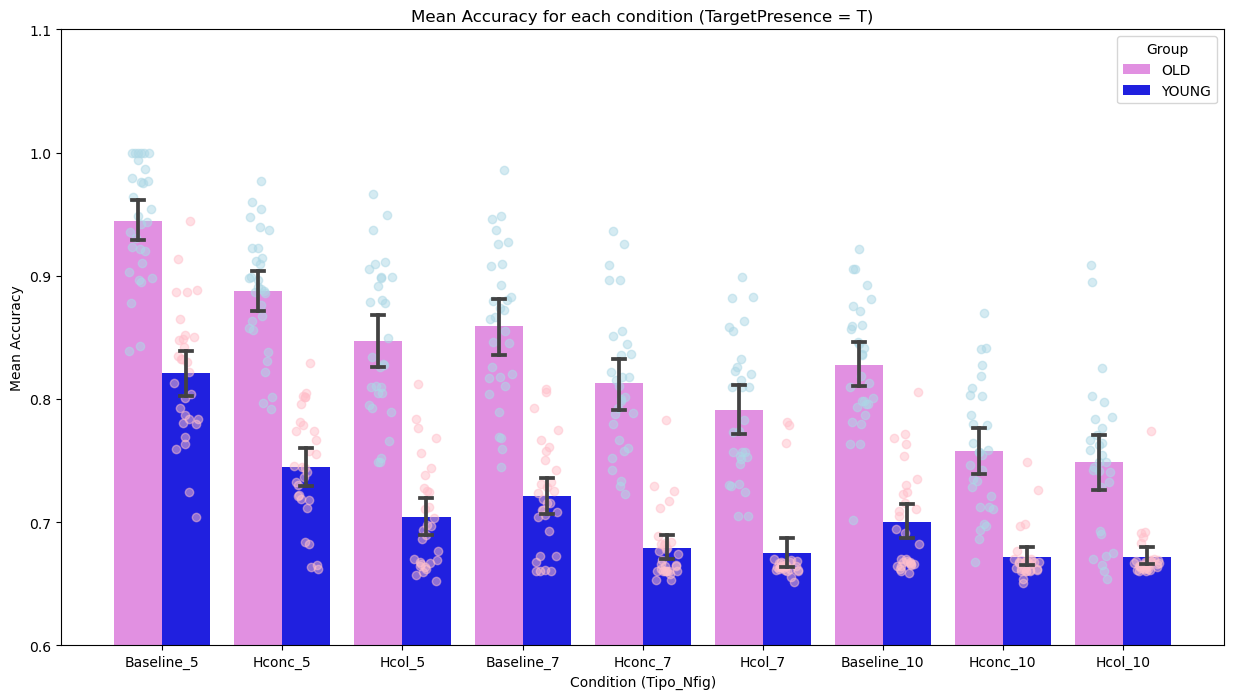

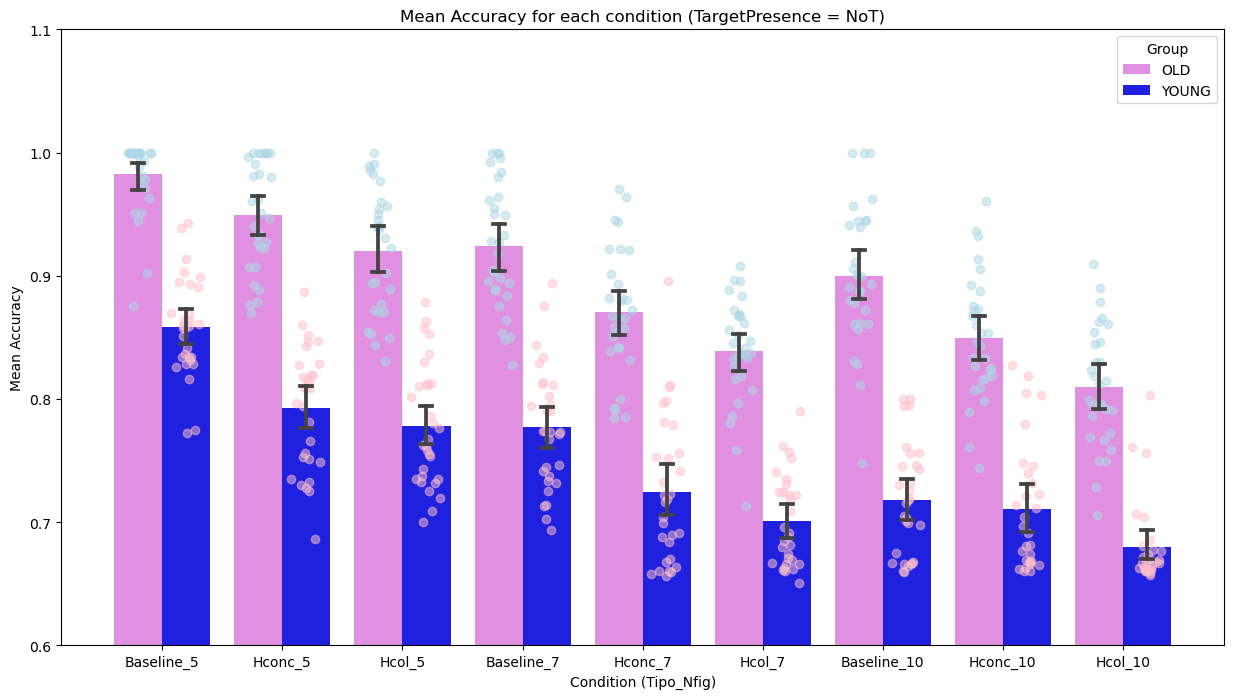

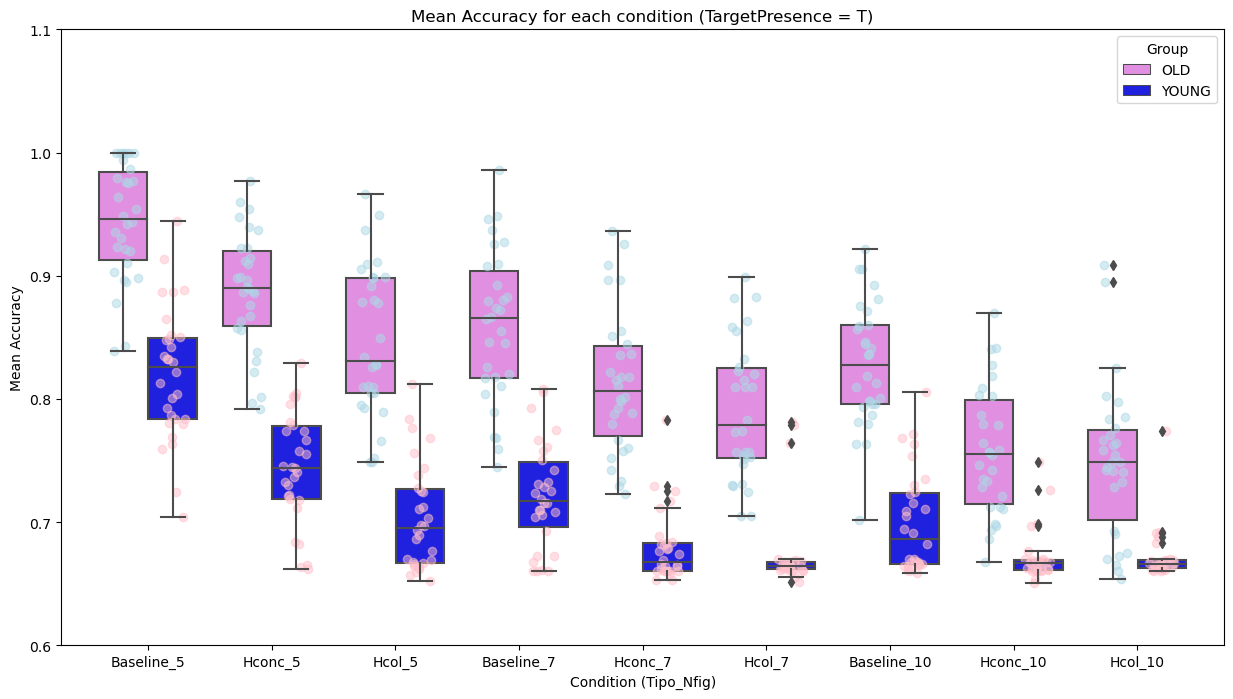

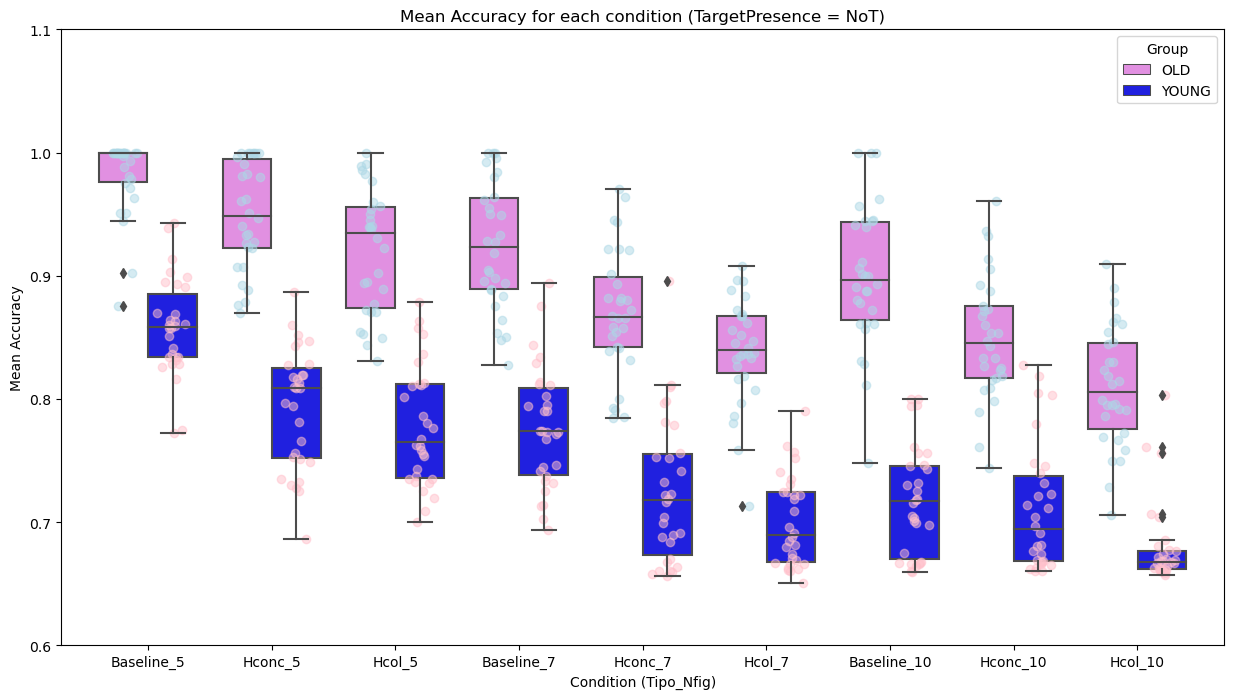

In [31]:
# STEP 13. visualization of mean Accuracy OLD vs YOUNG considering predictors interactions

# calculate the mean Accuracy for each possible interaction of all levels of the conditions
for Nfig in Nfig_levels:
    for Tipo in Tipo_levels:
        for TargetPresence in TargetPresence_levels:
            for Group in Group_levels:
                # filter the dataframe based on the current levels
                df_filtered = df_ideal[(df_ideal['Nfig'] == Nfig) &
                                                      (df_ideal['Tipo'] == Tipo) &
                                                      (df_ideal['TargetPresence'] == TargetPresence) &
                                                      (df_ideal['Group'] == Group)]
                
                # calculate the mean RT and standard error
                mean_acc = df_filtered['Accuracy'].mean()
                std_err_acc = df_filtered['Accuracy'].sem()
                
                # print the results
                print(f"Mean Accuracy for Nfig={Nfig}, Tipo={Tipo}, TargetPresence={TargetPresence}, Group={Group}: {mean_acc}, SE: {std_err_acc}")

# create two separate BAR plots according to TargetPresence
for TargetPresence in TargetPresence_levels:
    # filter the dataframe based on the current TargetPresence
    df_filtered = df_ideal[df_ideal['TargetPresence'] == TargetPresence]
    
    # create a bar plot with error bars
    plt.figure(figsize=(15, 8))
    sns.barplot(data=df_filtered, x='Tipo_Nfig', y='Accuracy', hue='Group', palette=color_dict, capsize=.1)
    
    # get the unique 'Tipo_Nfig' values
    unique_Tipo_Nfig = df_filtered['Tipo_Nfig'].unique()
    
    # add individual participant mean RT as jittered data points
    for Group in Group_levels:
        for i, Tipo_Nfig in enumerate(unique_Tipo_Nfig):
            # filter the dataframe based on the current 'Tipo_Nfig' and 'Group'
            df_filtered_Tipo_Nfig_Group = df_filtered[(df_filtered['Tipo_Nfig'] == Tipo_Nfig) & (df_filtered['Group'] == Group)]
            
            # get the unique participant IDs
            IDs = df_filtered_Tipo_Nfig_Group['ID'].unique()
            
            # plot the mean RT for each participant
            for ID in IDs:
                # introduce a horizontal offset for both 'Young' and 'Old' groups
                offset = -0.2 if Group == 'OLD' else 0.2
                # marker = 'x' if Group == 'YOUNG' else 'o'
                plt.scatter(i + offset + jitter_dict[(Nfig, Tipo, TargetPresence, Group, ID)], df_filtered_Tipo_Nfig_Group[df_filtered_Tipo_Nfig_Group['ID'] == ID]['Accuracy'].mean(), color=color_dict2[Group], alpha=0.5) #, marker=marker) 
    
    plt.ylim(0.6, 1.1)  # Set y-axis range
    plt.title(f'Mean Accuracy for each condition (TargetPresence = {TargetPresence})')
    plt.xlabel('Condition (Tipo_Nfig)')
    plt.ylabel('Mean Accuracy')
    
    # show the plot
    plt.show()
    
# create two separate BOXPLOTS according to TargetPresence
for TargetPresence in TargetPresence_levels:
    # filter the dataframe based on the current TargetPresence
    df_filtered = df_ideal[df_ideal['TargetPresence'] == TargetPresence]
    
    # set size of the plot
    plt.figure(figsize=(15, 8)) 
    # create a box plot with jittered data points
    sns.boxplot(data=df_filtered, x='Tipo_Nfig', y='Accuracy', hue='Group', palette=color_dict)
    
    
    # get the unique 'Tipo_Nfig' values
    unique_Tipo_Nfig = df_filtered['Tipo_Nfig'].unique()
    
    # add individual participant mean RT as jittered data points
    for Group in Group_levels:
        for i, Tipo_Nfig in enumerate(unique_Tipo_Nfig):
            # filter the dataframe based on the current 'Tipo_Nfig' and 'Group'
            df_filtered_Tipo_Nfig_Group = df_filtered[(df_filtered['Tipo_Nfig'] == Tipo_Nfig) & (df_filtered['Group'] == Group)]
            
            # get the unique participant IDs
            IDs = df_filtered_Tipo_Nfig_Group['ID'].unique()
            
            # plot the mean RT for each participant
            for ID in IDs:
                # introduce a horizontal offset for both 'Young' and 'Old' groups
                offset = -0.2 if Group == 'OLD' else 0.2
                # marker = 'x' if Group == 'YOUNG' else 'o'
                plt.scatter(i + offset + jitter_dict[(Nfig, Tipo, TargetPresence, Group, ID)], df_filtered_Tipo_Nfig_Group[df_filtered_Tipo_Nfig_Group['ID'] == ID]['Accuracy'].mean(), color=color_dict2[Group], alpha=0.5) #, marker=marker) 
    
    plt.ylim(0.6, 1.1)  # Set y-axis range
    plt.title(f'Mean Accuracy for each condition (TargetPresence = {TargetPresence})')
    plt.xlabel('Condition (Tipo_Nfig)')
    plt.ylabel('Mean Accuracy')
    
    # show the plot
    plt.show()